Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install systole

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from systole.detection import ecg_peaks
from systole.correction import correct_rr, correct_peaks
from systole.plots import plot_subspaces, plot_raw, plot_rr, plot_frequency, plot_evoked
from systole import import_dataset1
from systole.utils import input_conversion

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Detecting and correcting artefacts
In this notebook, we introduce two methods for artefact detection and correction based on the peaks vector or the RR time series, respectively. ECG and PPG recording and the resulting R-R interval time series can be noisy, either due to artefacts in the signal or invalid peak detection. Common sources of signal artefacts in the signal are participant movements or sub-optimal recording setup (e.g., power line noise). These artefacts can be attenuated or removed by using appropriate filtering approaches, or ultimately by checking the recorded signal and manually correcting the time series. However, even when using valid ECG and PPG recording, the heart can adapt its frequency in a way that can appear unlikely considering the RR intervals distributions and dynamics. Artefact detection and correction methods try to dissociate true artefacts induced by low-quality signals and irregular heart rate frequency.

In [3]:
# Import ECg recording
ecg_df = import_dataset1(modalities=['ECG', "Stim"])

# Select the first minute of recording
signal = ecg_df.ecg.to_numpy()

# R peaks detection
signal, peaks = ecg_peaks(signal, method='pan-tompkins', sfreq=1000)

# Convert peaks vector to RR time series
rr = input_conversion(peaks, input_type='peaks', output_type='rr_ms')

Following **[1]**, we distinguish between three kinds of irregular RR intervals, aka inter-beat intervals (IBIs):
1. Missing R peaks / long beats. This artefact corresponds to an interval that is longer than expected. The missed peaks suggest that an actual heartbeat was not correctly detected.
2. Extra R peaks or short beats. This artefact corresponds to an interval that is shorter than expected. The extra peak suggests that an R wave is erroneously detected.
3. Ectopic beats forming negative-positive-negative (NPN) or positive-negative-positive (PNP) segments.

Heart rate variability metrics are highly sensitive to such R-R artefacts, it is therefore critical to perform a careful artefact detection and correction procedure before extracting the heart rate variability metrics.

## Artefacts detection
[Systole](https://systole-docs.github.io/) implements artefact detection based on adaptive thresholding of first and second derivatives of the R-R interval time series (see **[1]** for a description of the method). One way to visualize the distribution of regular and irregular intervals is to use the transformation plotted below, which can be used to detect ectopic beats and long/short intervals. In the figure, the grey areas indicate the range of unlikely values considering each artefacts subtype. The intervals that are falling in these areas will be labelled as irregular.

In [4]:
show(
    plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
)

It is also possible to automatically propagate this information to the R-R interval time series plot itself so we can visualize exactly where the artefacts are located in the signal. You can achieve this behavior by setting `show_artefacts` to `True`.

In [5]:
show(
    plot_raw(signal, backend='bokeh', show_artefacts=True, show_heart_rate=True, figsize=300)
)

As we can see in the figure above, the majority of detected R peaks are correctly localized, and the RR interval time series for the most part well estimated. There are few notable exceptions however, including extra R waves and the erroneous detection of artefacts around these areas. Note that, because the artefact detection method uses different orders of the derivative to estimate the regularity of the interval, the presence of actual artefacts can distort this process and induce false-positive around the true artefacts. That is why data cleaning should proceed first with the correction of the more salient divergences (i.e., missed and extra peaks) before correcting the less salient ones (i.e., long and short peaks). The correction of ectopic beats is more nuanced and depends on the exact experimental context (see below).

## Artefact correction

Well-calibrated automated R-R intervals artefact detection can often find issues that mere visual inspection of raw data may miss. Corrected these artefacts can in turn help to estimate heart rate variability more accurately, limiting the occurence of erroneous conclusions (i.e., type-I and type-II errors). The appropriate correction method depends on the nature of the artefact. It can be something that you might want to code yourself or correct manually by placing or removing peaks in the raw signal. It can also be a more automated process - regardless of the choice of automatic or manual correction, the correction procedure should be documented in a transparent and reproducible manner.

Systole provides two correction methods (`correct_rr` and `correct_peaks`). The choice between these two methods mostly depends on the level of signal preservation we want to achieve after correction: do we want to recreate a new RR time series that does not contains irregular intervals, or do we want a better detection of the R peaks themselves?

1. **correct_rr**: will operate on the RR time series directly and will return another time series that *can have a different timing* (as the cumulative sum of the R interval will change).
2. **correct_peaks**: will operate on the peaks vector directly. The number of peaks (and therefore the RR intervals) can vary, but the timing will remain constant.

The approach is often prefered for heart rate variability studies. In this case, long recordings of the heart rate (>5 minutes) are used and a robust estimate of some HRV metrics is estimated.  Because we do not want this estimate to be contaminated by extreme RR intervals or even smaller deviations, those intervals are corrected by interpolation to make the time series as standard as possible, sacrificing the temporal precision of the heartbeat occurrence.

The second method is more appropriate when the temporal precision of the heartbeat detection is relevant (this can concern heartbeat evoked potentials or instantaneous heart rate variability when it is time-locked to some specific stimuli, see tutorial **5)**. In this case, instead of blind interpolation, the raw signal time series can be used to re-estimate the peaks.

### Correcting atefacts in RR time series

**Note:** see also the example `Detecting and correcting artefacts in RR time series` in the example gallery.

To illustrate how the `correct_rr` method can remove RR artefacts, we will use the RR interval time series extracted from the previous recording.

In [6]:
# Convert the peaks vector into RR intervals time series.
rr_ms = input_conversion(peaks, input_type="peaks", output_type="rr_ms")

#### Creating artefacts

For now, this time series it not severely artefacted. But we can easily simulate missed peaks and extra peaks by manually increasing or decreasing the length of some RR intervals.

In [7]:
np.random.seed(123)  # For result reproducibility

corrupted_rr = rr_ms.copy()  # Create a new RR intervals vector

# Randomly select 50 intervals in the time series and multiply them by 2 (missed peaks)
corrupted_rr[np.random.choice(len(corrupted_rr), 50)] *= 2

# Randomly select 50 intervals in the time series and divide them by 3 (missed peaks)
corrupted_rr[np.random.choice(len(corrupted_rr), 50)] /= 3

Lets see if the artefact we created are correctly detected. Note that here, we are using `show_artefacts=True` so the artefacts detection runs automatically and shows in the plot.

In [8]:
show(
    plot_rr(corrupted_rr, input_type="rr_ms", show_artefacts=True,  line=False, backend="bokeh", figsize=300)
)

#### Correcting artefacts

The artefacts simulation seems to work fine so far. We have created abnormal long and short RR intervals and they are later correctly detected. We can now apply the RR time series correction method. This function will automatically detect possible artefacts in the RR intervals and reconstruct the most probable value using time series interpolation. The number of iteration is set to `2` by default, we add it here for clarity.

In [9]:
rr_correction = correct_rr(corrupted_rr, n_iterations=2)

Cleaning the RR interval time series using 2 iterations.
 - Iteration 1 - 
... correcting 43 missed interval(s).
... correcting 18 ectopic interval(s).
... correcting 51 short interval(s).
... correcting 7 long interval(s).
 - Iteration 2 - 
... correcting 1 missed interval(s).
... correcting 4 ectopic interval(s).


Let's now have a look at the corrected RR time series.

In [10]:
show(
    plot_rr(rr_correction["clean_rr"], input_type='rr_ms', backend="bokeh", show_artefacts=True, line=False, figsize=300)
)

#### Visualization of the correction quality

We can see that after two iterations, nearly all of of the artefacts have been corrected. This does not means that the new values match exactly the RR intervals, and the new corrected time series will always slightly differ from the original one. However, we can estimate how large this difference is by comparing the true, corrupted and corrected time series a posteriori. Here, instead of comparing the time series side by side, we can inspect HRV metrics that are known to be affected by RR artefacts, like the high frequency HRV.

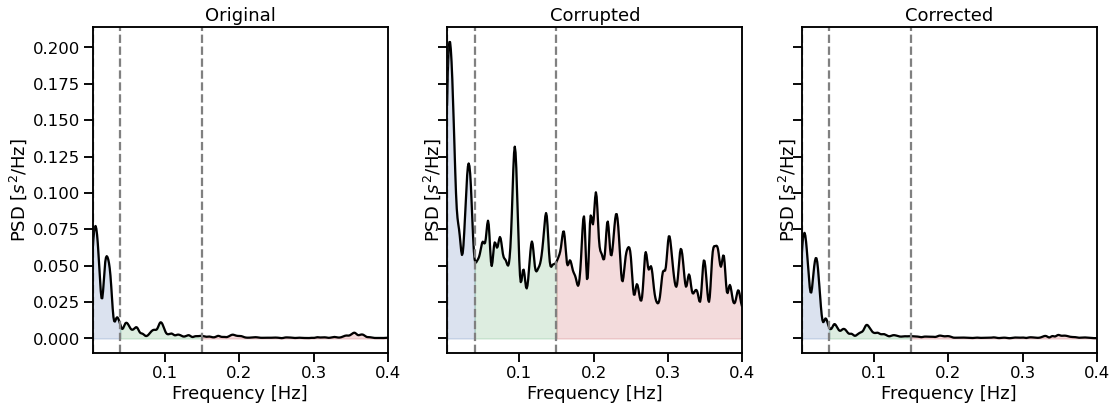

In [11]:
_, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, rr, lab in zip(range(3), 
                 [rr_ms, corrupted_rr, rr_correction["clean_rr"]],
                 ["Original", "Corrupted", "Corrected"]):
    plot_frequency(rr, input_type="rr_ms", ax=axs[i])
    axs[i].set_title(lab)

### Correcting artefacts in peaks vector

**Note:** see also the exxample `Detecting and correcting artefacts in RR time series` in the example gallery.

Here, we are going to use the same recording, but this time correcting directly the peaks vector to demonstrate the use of `correct_peaks`.

#### Creating artefacts

In [12]:
np.random.seed(123)  # For result reproductibility

corrupted_peaks = peaks.copy()  # Create a new RR intervals vector

# Randomly select 50 peaks in the peask vector and set it to 0 (missed peaks)
corrupted_peaks[np.random.choice(np.where(corrupted_peaks)[0], 50)] = 0

# Randomly add 50 intervals in the peaks vector (extra peaks)
corrupted_peaks[np.random.choice(len(corrupted_peaks), 50)] = 1

In [13]:
show(
    plot_rr(corrupted_peaks, input_type="peaks", show_artefacts=True,  line=False, backend="bokeh", figsize=300)
)

#### Correcting artefacts

Again, the simulated artefact detection has worked as intended. We can now apply the peak correction method. This function will automatically detect possible artefacts in the peak vector and reconstruct the most coherent values using time series interpolation. The number of iteration is set to `2` by default, we add it here for clarity. Here, the `correct_peaks` function only correct for extra and missed peaks. This feature is intentional and reflects the notion that only artefacts in R peaks detection should be corrected, but "true" intervals that are anomaly shorter or longer should not be corrected.

In [14]:
peaks_correction = correct_peaks(corrupted_peaks)

Cleaning the peaks vector using 2 iterations.
 - Iteration 1 - 
... correcting 47 extra peak(s).
... correcting 45 missed peak(s).
 - Iteration 2 - 
... correcting 2 extra peak(s).
... correcting 1 missed peak(s).


In [15]:
show(
    plot_rr(peaks_correction["clean_peaks"], input_type="peaks", show_artefacts=True,  line=False, backend="bokeh", figsize=300)
)

#### Visualization of the correction quality

As previously mentioned, this method is more appropriate in the context of event-related analysis, where the evolution of the instantaneous heart rate is assessed after some experimental manipulation (see Tutorial 5). One way to control for the quality of the artefact correction is to compare the evoked responses measured under corrupted, corrected and baseline recording. Here, we will use the `plot_evoked` function, which simply take the indexes of events as input together with the recording (here the peaks vector), and produce the evoked plots.

In [16]:
# Merge the two conditions together.
# The events of interest are all data points that are not 0.
triggers_idx = [np.where(ecg_df.stim.to_numpy() != 0)[0]]

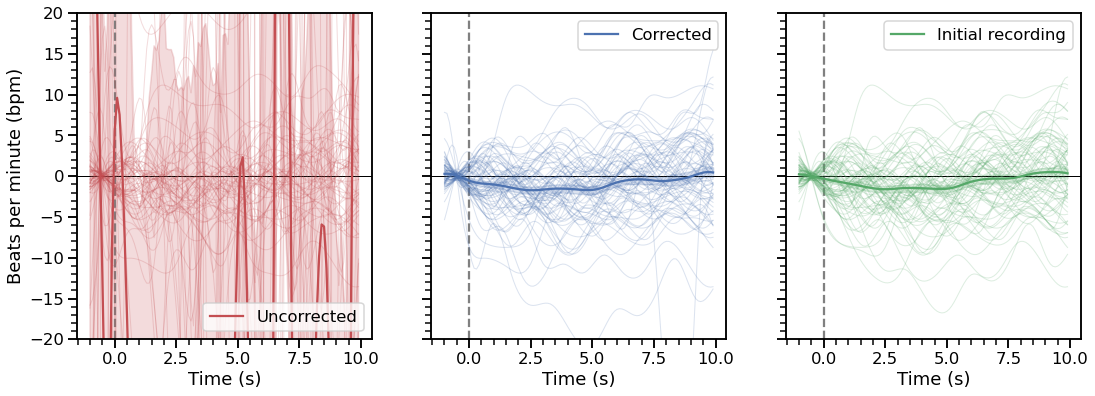

In [17]:
_, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plot_evoked(rr=corrupted_peaks, triggers_idx=triggers_idx, ci=68,
            input_type="peaks", decim=100, apply_baseline=(-1.0, 0.0), figsize=(8, 8),
            labels="Uncorrected", palette=["#c44e52"], ax=axs[0])
plot_evoked(rr=peaks_correction["clean_peaks"], triggers_idx=triggers_idx, ci=68,
            input_type="peaks", decim=100, apply_baseline=(-1.0, 0.0), figsize=(8, 8),
            labels="Corrected", ax=axs[1])
plot_evoked(rr=peaks, triggers_idx=triggers_idx, ci=68, palette=["#55a868"],
            input_type="peaks", decim=100, apply_baseline=(-1.0, 0.0), figsize=(8, 8),
            labels="Initial recording", ax=axs[2])
plt.ylim(-20, 20);

This concludes the tutorial on using Systole to detect and correct more complex artefacts. In the next tutorial we will introduce more advanced signal processing techniques for estimating low and high-frequency heart-rate variability. 

**References**

**[1]** Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time series artefact correction using novel beat classification. Journal of Medical Engineering & Technology, 43(3), 173–181. https://doi.org/10.1080/03091902.2019.1640306